<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Projeto** | Pipeline de Dados do Telegram II
<br>

Aluno [Denner Martins](https://www.linkedin.com/in/denner-martins-/)

Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Introdução;</li>
  <li>Contexto;</li>
  <li>Telegram API;</li>
  <li>Dados;</li>
  <li>ETL;</li>
  <li>Apresentação;</li>
  <li>Conclusão.</li>
</ol>

# **1. Introdução**

# **Um Pipeline Eficiente**
Imagine um grupo no Telegram onde usuários compartilham informações importantes ou dados específicos que precisam ser processados e analisados. O fluxo começa aqui, com um bot no Telegram que atua como o ponto de entrada para toda a solução. Este bot monitora o grupo e recebe mensagens ou eventos enviados pelos usuários. A partir daí, ele inicia uma sequência bem planejada de ações dentro da infraestrutura na AWS, garantindo o processamento eficiente dos dados.

# **2. Contexto**

# **2.1. Chatbot**

Um chatbot é um tipo de software que interage com usuários através de conversas automatizadas em plataformas de mensagens. Uma aplicação comum de chatbots é o seu uso no atendimento ao cliente, onde, de maneira geral, ajudam clientes a resolver problemas ou esclarecer dúvidas recorrentes antes mesmo que um atendente humano seja acionado.

# **2.2. Telegram**

**Telegram** é uma plataforma de mensagens instantâneas *freeware* (distribuído gratuitamente) e, em sua maioria, *open source*. É muito popular entre desenvolvedores por ser pioneiro na implantação da funcionalidade de criação de **chatbots**, que, por sua vez, permitem a criação de diversas automações.

# **2.3. Arquitetura**

Uma atividade analítica de interesse é a de realizar a análise exploratória de dados enviadas a um **chatbot** para responder perguntas como:

1. Qual o horário que os usuários mais acionam o *bot*?
1. Qual o problema ou dúvida mais frequente?
1. O *bot* está conseguindo resolver os problemas ou esclarecer as dúvidas?
1. Etc.

Portanto, vamos construir um *pipeline* de dados que ingira, processe, armazene e exponha mensagens de um grupo do **Telegram** para que profissionais de dados possam realizar análises. A arquitetura proposta é dividida em duas: transacional, no **Telegram**, onde os dados são produzidos, e analítica, na Amazon Web Services (AWS), onde os dados são analisados.

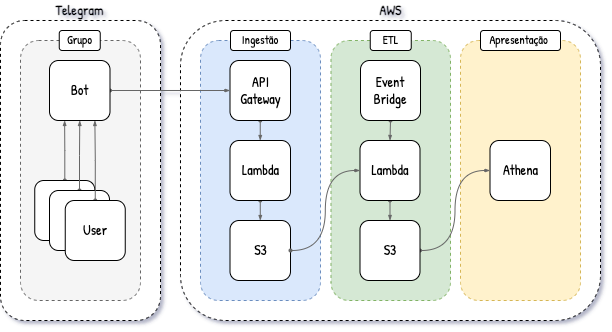

# **3. Telegram API**

O **Telegram** representa a fonte transacional de dados do nosso *pipeline* de dados. Nesta etapa, vamos criar um grupo, criar um **bot** e adiciona-lo ao grupo recém criado. O *bot* então captará **todas** as mensagens enviadas no grupo. As mensagens pode ser acessadas através da API (*application programming interface*) de *bots* dos **Telegram** (documentação neste [link](https://core.telegram.org/bots/api)).

# **3.1 Criando Bot e o Grupo**

# **Bot**

1. Abra o *chat* com o `BotFather`;
1. Digite `/newbot`;
1. Digite o nome do *bot*;
1. Digite o nome de usuário do *bot* (precisa terminar com sufixo `_bot`);

Nome do Bot: **Odair**

Nome de usuário do Bot: **M42_Denner_Bot**

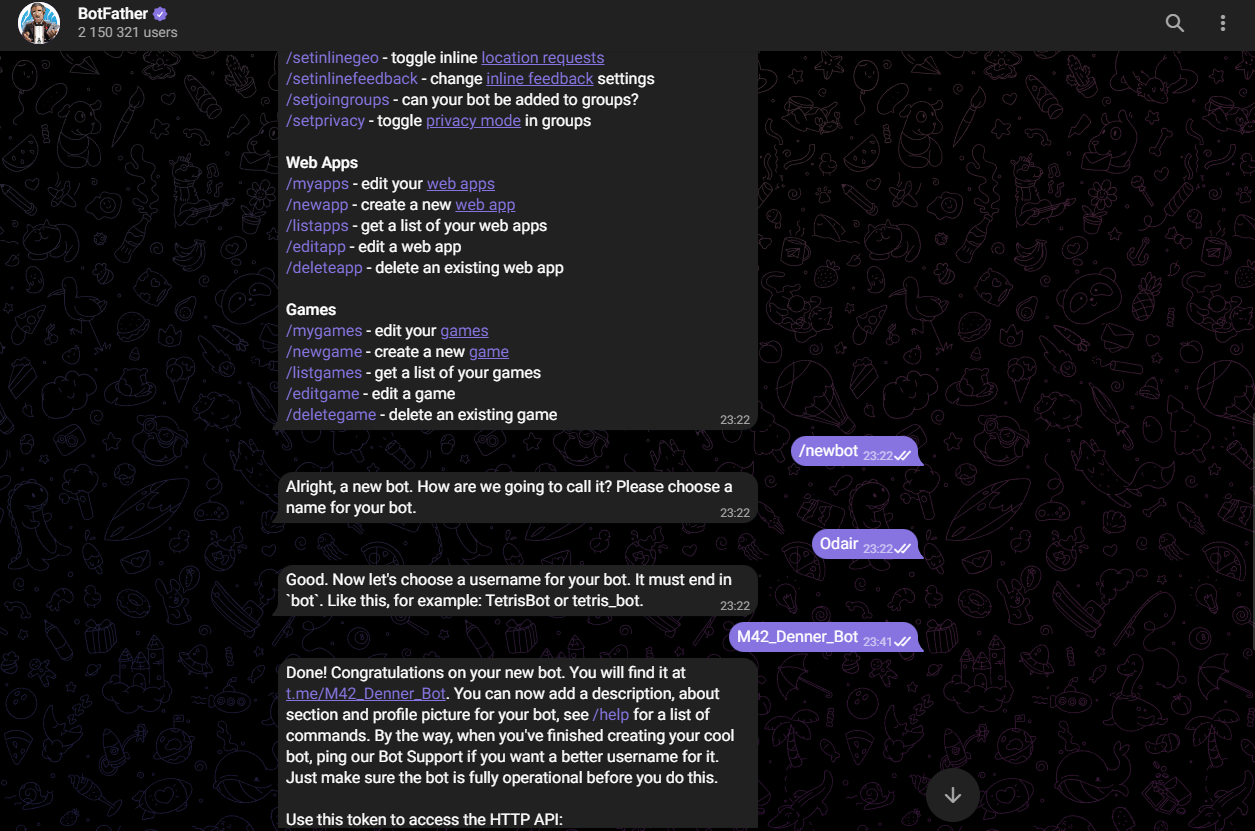

# **Grupo**

1. Aperte o botão com o ícone de um lápis;
1. Selecione `New Group`;
1. Busque e selecione o *bot* recém criado pelo seu nome;
1. Aperte o botão com o ícone de uma seta;
1. Digite o nome do grupo.

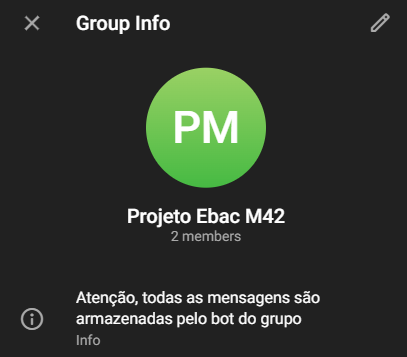

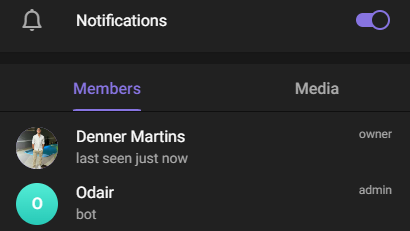

**Com tudo pronto, envie algumas mensagens no grupo.**

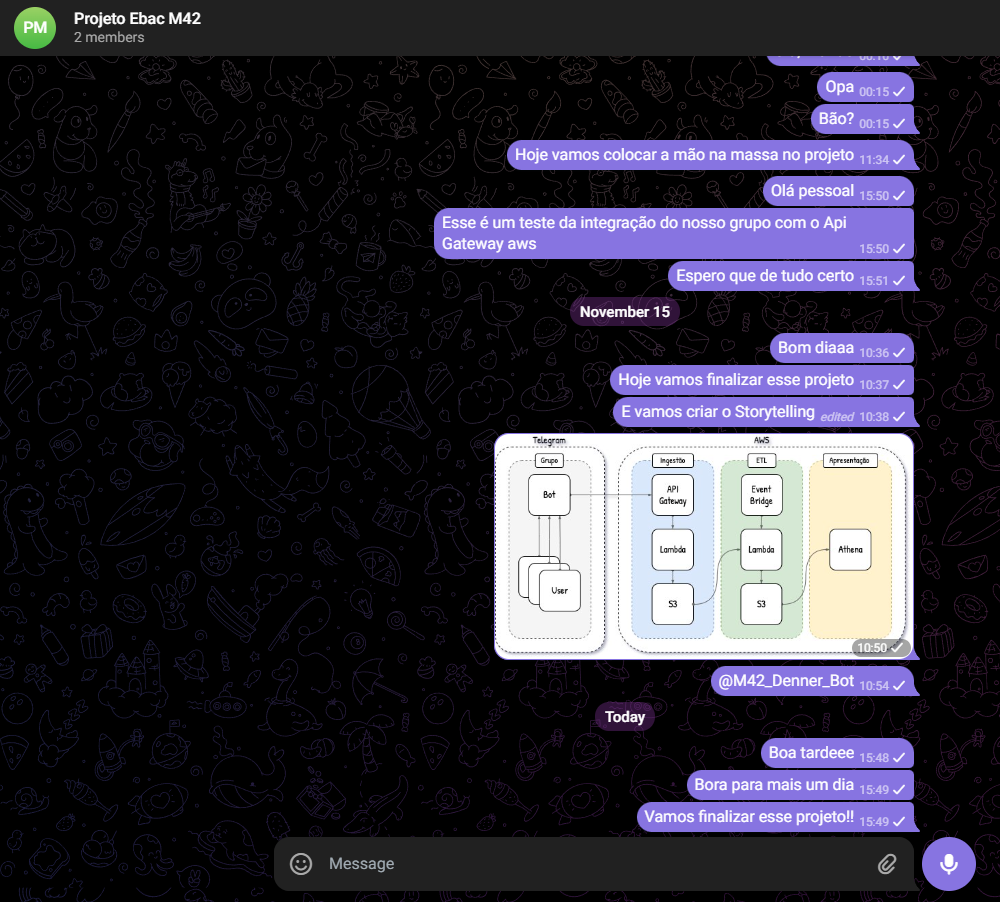

# **3.2 Bot API**

As mensagens captadas por um *bot* podem ser acessadas via API. A única informação necessária é o `token` de acesso fornecido pelo `BotFather` na criação do *bot*.

> **Nota:** A documentação completa da API pode ser encontrada neste [link](https://core.telegram.org/bots/api)

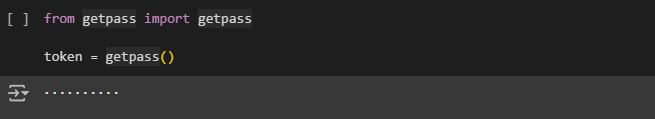

A `url` base é comum a todos os métodos da API.

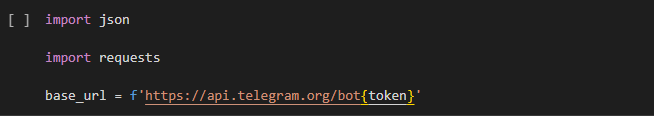

 - **getUpdates**

O método `getMe` retorna as mensagens captadas pelo *bot*.

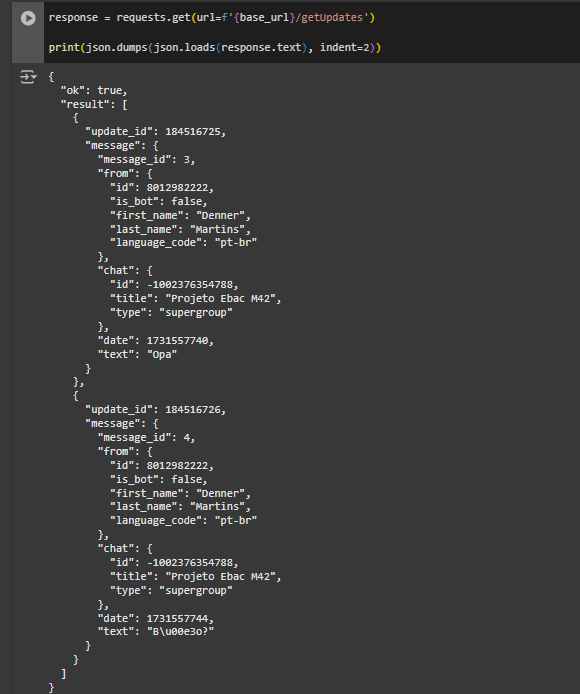

# **4. Dados**

# **4.1 Conectando o Telegram à AWS**

# **Ingestão dos Dados**

Assim que o bot captura as informações no grupo, ele as encaminha para a API Gateway na AWS. A API Gateway é o primeiro ponto de contato na nuvem, funcionando como uma interface para receber as solicitações do Telegram.

A etapa de **ingestão** é responsável, como seu o próprio nome diz, pela ingestão dos dados transacionais em ambientes analíticos. De maneira geral, o dado ingerido é persistido no formato mais próximo do original, ou seja, nenhuma transformação é realizada em seu conteúdo ou estrutura (*schema*). Como exemplo, dados de uma API *web* que segue o formato REST (*representational state transfer*) são entregues, logo, persistidos, no formato JSON.

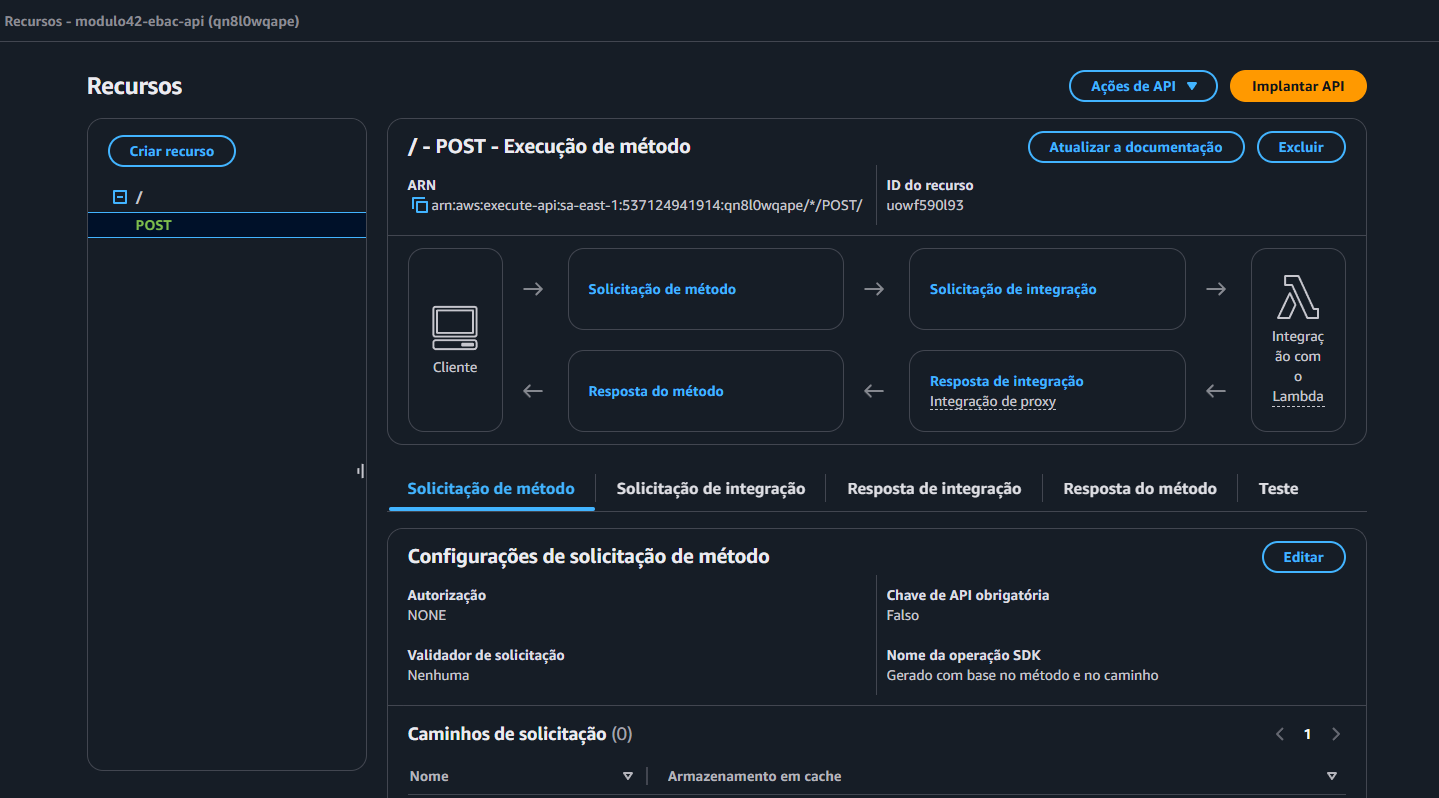

Depois de receber os dados, a API Gateway aciona uma função AWS Lambda, que processa rapidamente as informações recebidas. A função Lambda pode realizar tarefas como validação, formatação dos dados e registro de eventos. Em seguida, esses dados processados são armazenados em um bucket no Amazon S3, onde ficam organizados e prontos para a próxima etapa.

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

**Repare na imagem abaixo como o API GATEWAY se conecta com o AWS LAMBDA**

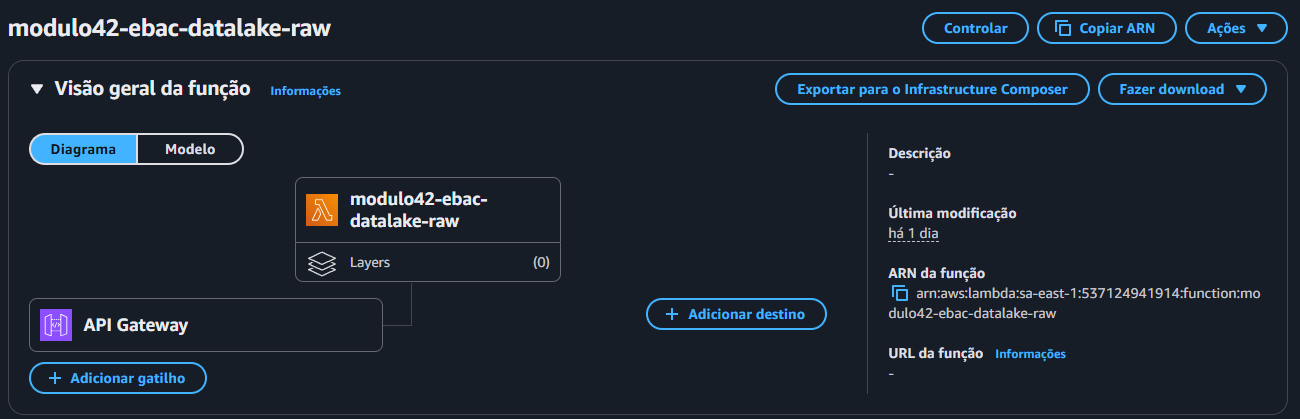

Aqui os arquivos **RAW** estão entrando com sucesso no **Bucket do S3**

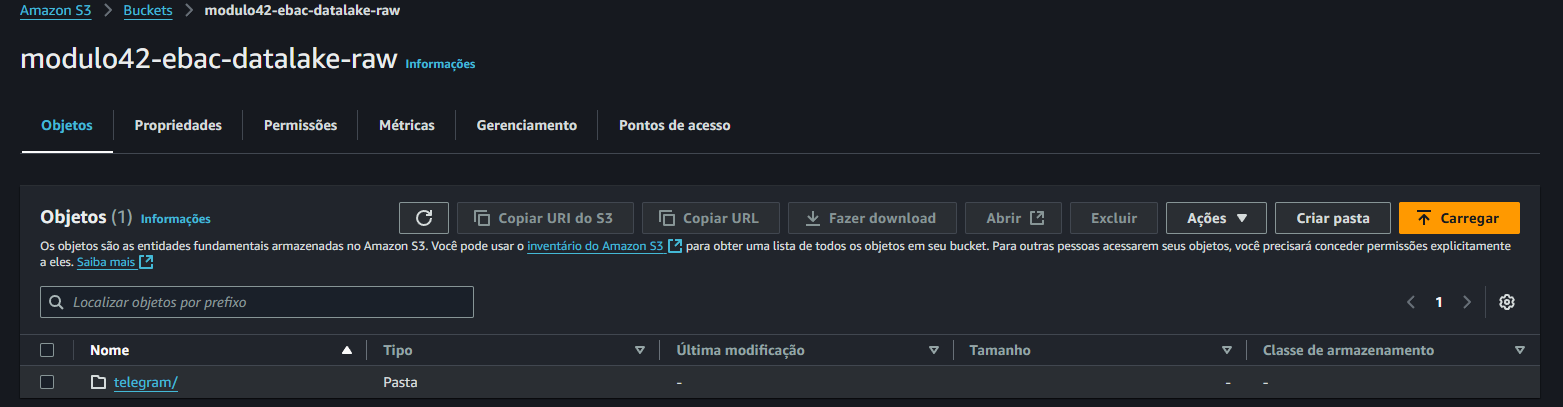

# **5. ETL(Extração, Transformação e Carregamento)**

A etapa de **extração, transformação e carregamento** (do inglês *extraction, transformation and load* ou **ETL**) é uma etapa abrangente responsável pela manipulação dos dados ingeridos de sistemas transacionais, ou seja, já persistidos em camadas cruas ou *raw* de sistemas analíticos. Os processos conduzidos nesta etapa variam bastante de acordo com a área da empresa, do volume/variedade/velocidade do dado consumido, etc. Contudo, em geral, o dado cru ingerido passa por um processo recorrente de *data wrangling* onde o dado é limpo, deduplicado, etc. e persistido com técnicas de particionamento, orientação a coluna e compressão. Por fim, o dado processado está pronto para ser analisado por profissionais de dados.

Agora que os dados estão armazenados no S3, o foco se volta para o processamento e transformação. Um evento no Amazon EventBridge é configurado para monitorar o bucket S3 e acionar outra função AWS Lambda sempre que novos dados forem adicionados.

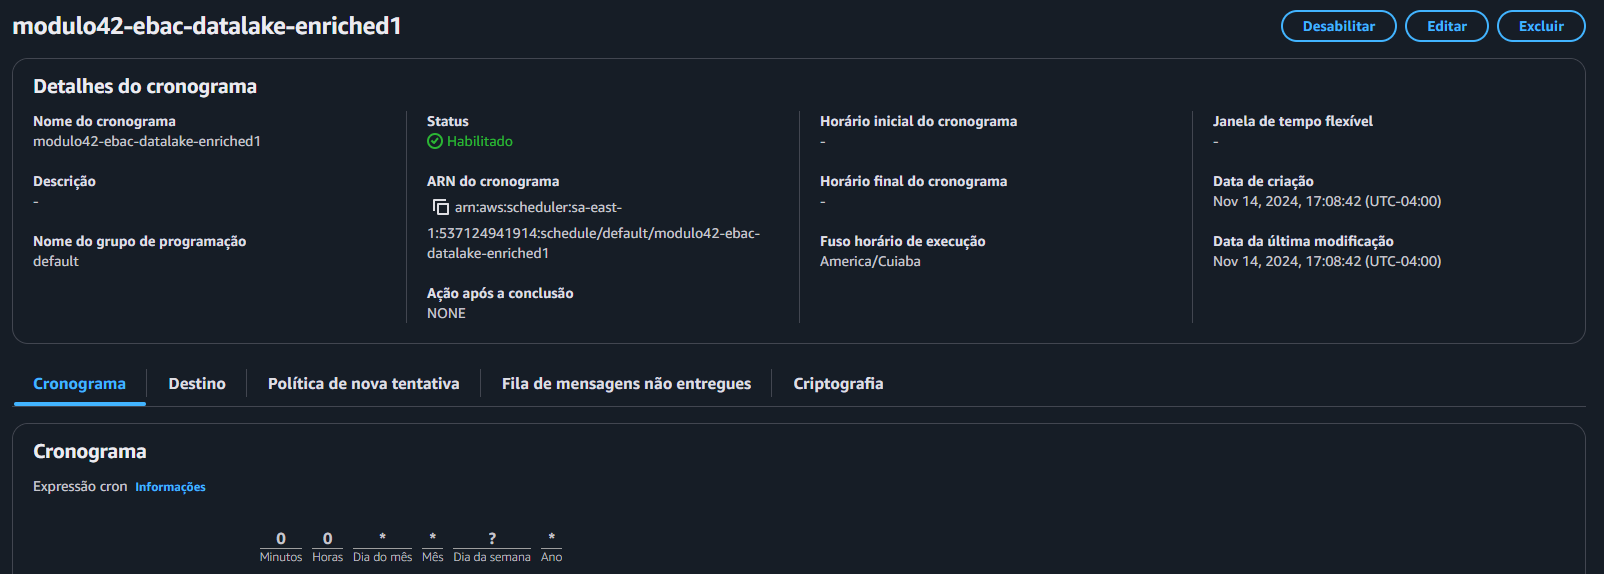

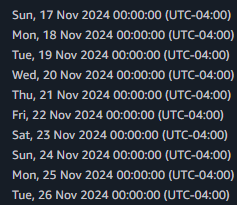

Vamos utilizar uma função do `AWS Lambda` como motor de processamento e um *bucket* do `AWS S3` como camada enriquecida para a persistência do dado processado.

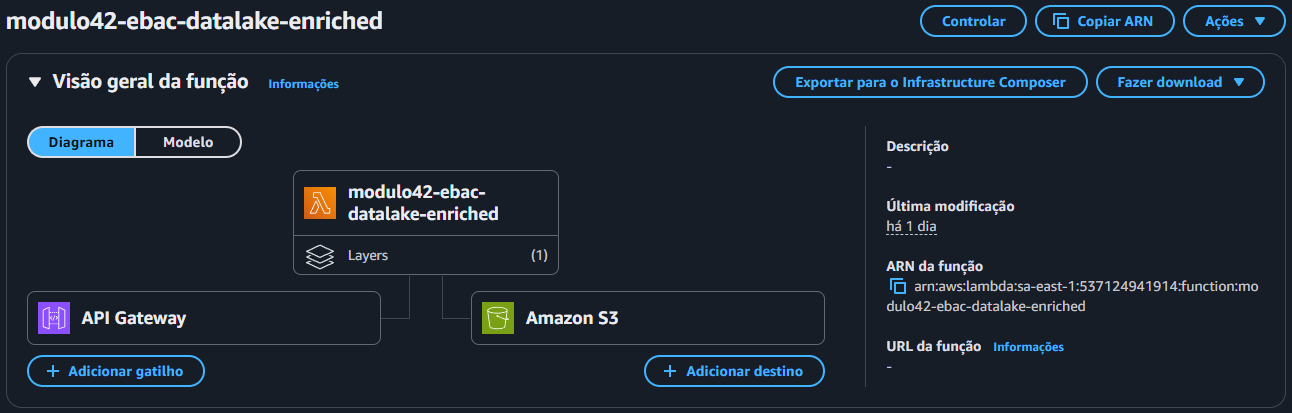

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

O código da função de *data wrangling*:

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

> **Nota**: Para testar a função, substitua o código `date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')` por `date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')`, permitindo assim o processamento de mensagens de um mesmo dia.

Nesta etapa, a função Lambda realiza o trabalho de ETL (Extração, Transformação e Carga). Isso pode incluir operações como limpar dados redundantes, agregar informações relevantes ou reformular o formato para facilitar análises futuras. Os resultados desse processamento são armazenados novamente em outro bucket no S3, garantindo que os dados estejam prontos para consulta.

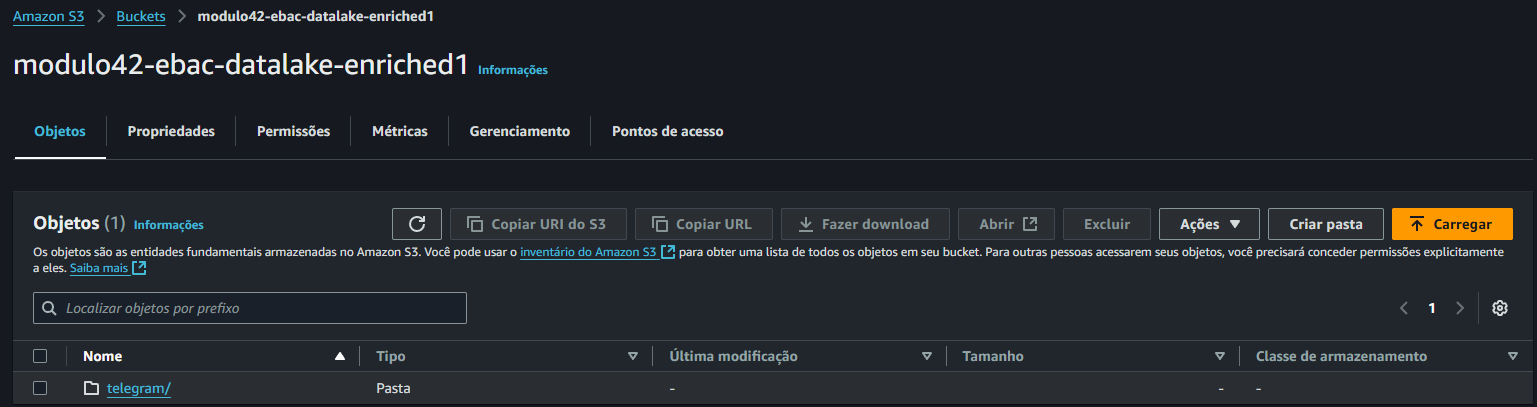

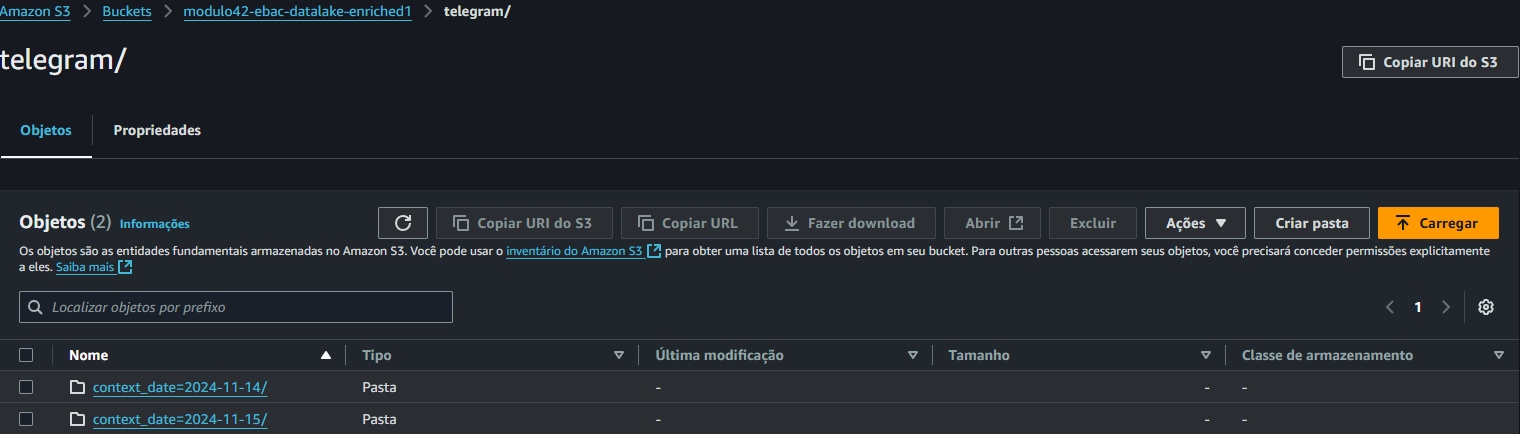

# **6. Apresentação**

Com os dados já tratados e organizados, chega a hora de torná-los acessíveis para análise e tomada de decisão. É aqui que entra o Amazon Athena, um serviço de consulta interativo que permite explorar os dados diretamente no bucket do S3 usando SQL.

**Criando a Tabela**

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://modulo42-ebac-datalake-enriched1/telegram/'
```

**Carregando as Partições**

```sql
MSCK REPAIR TABLE `telegram`;
```

# **6.1. Analytics**

No Athena, é possível executar consultas complexas, criar relatórios e extrair insights valiosos das informações enviadas pelo Telegram. Assim, toda a jornada dos dados, desde o grupo no Telegram até a análise no Athena, é concluída de maneira eficiente e automatizada.

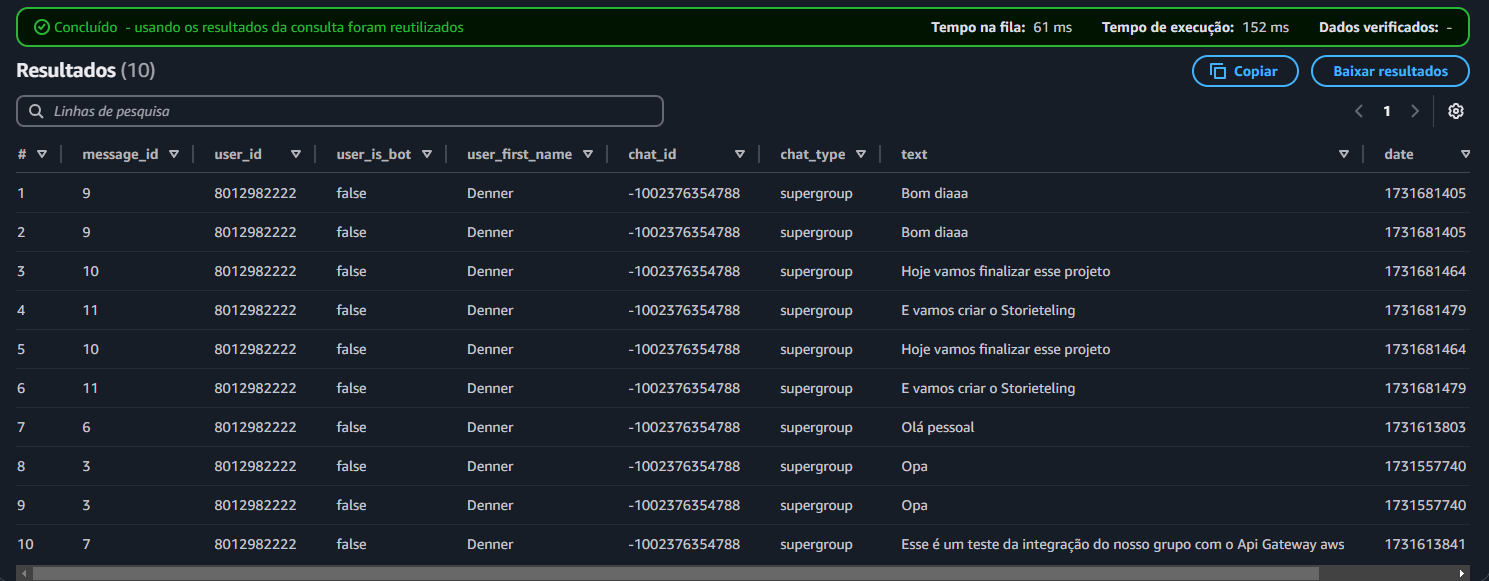

- Quantidade de mensagens por dia.

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

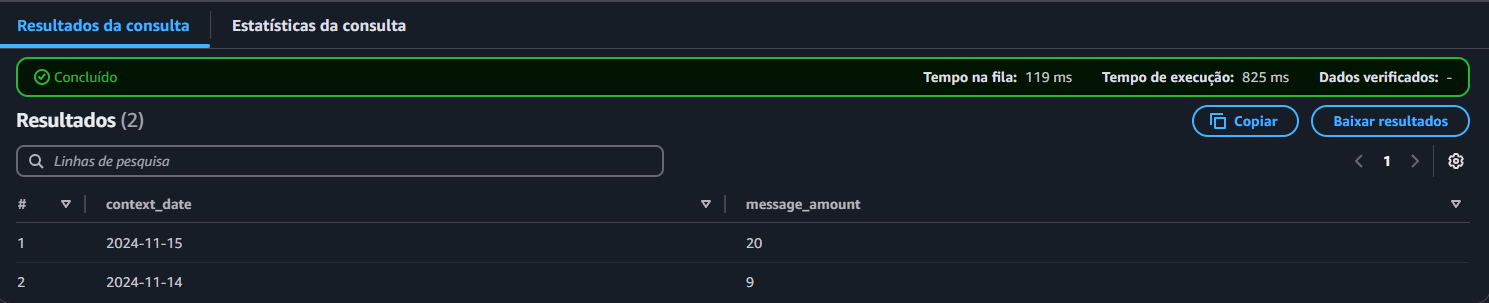

- Quantidade de mensagens por hora por dia da semana por número da semana.

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

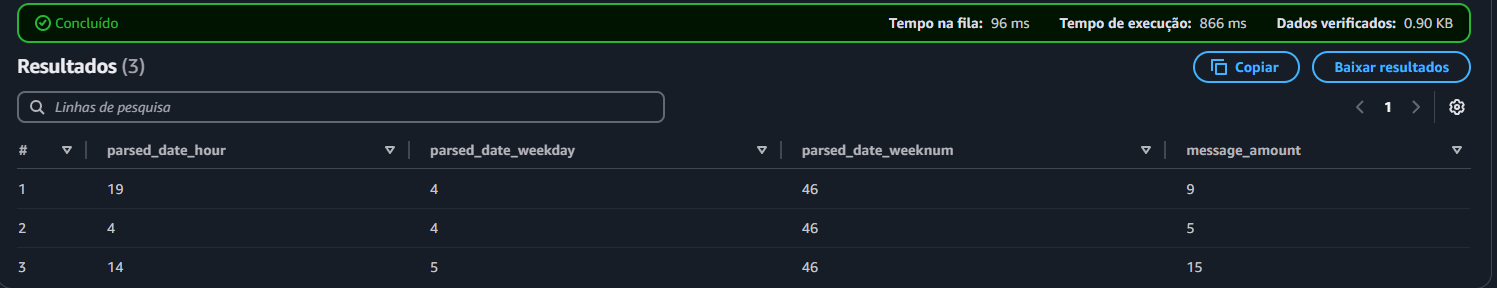

- Consultar Mensagens por Usuário

```sql
SELECT
    user_first_name,
    COUNT(*) AS total_mensagens
FROM telegram
GROUP BY user_first_name
ORDER BY total_mensagens DESC
LIMIT 10;


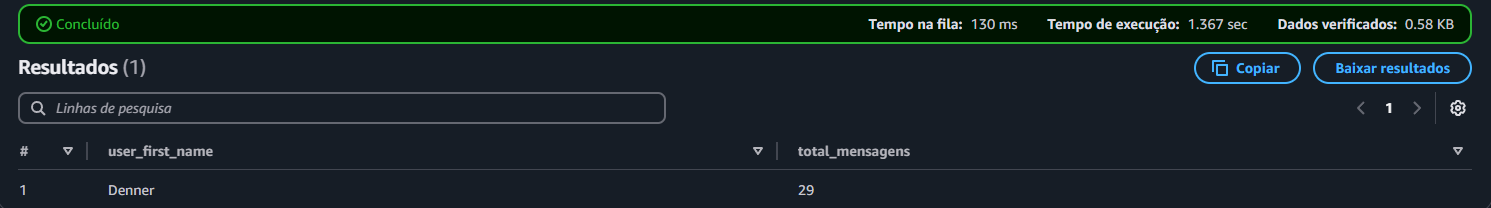

- Filtrar Mensagens Contendo Palavras-chave

```sql
SELECT
    user_first_name,
    text,
    FROM_UNIXTIME(date) AS data_envio
FROM telegram
WHERE LOWER(text) LIKE '%bom diaa%'
ORDER BY data_envio DESC;


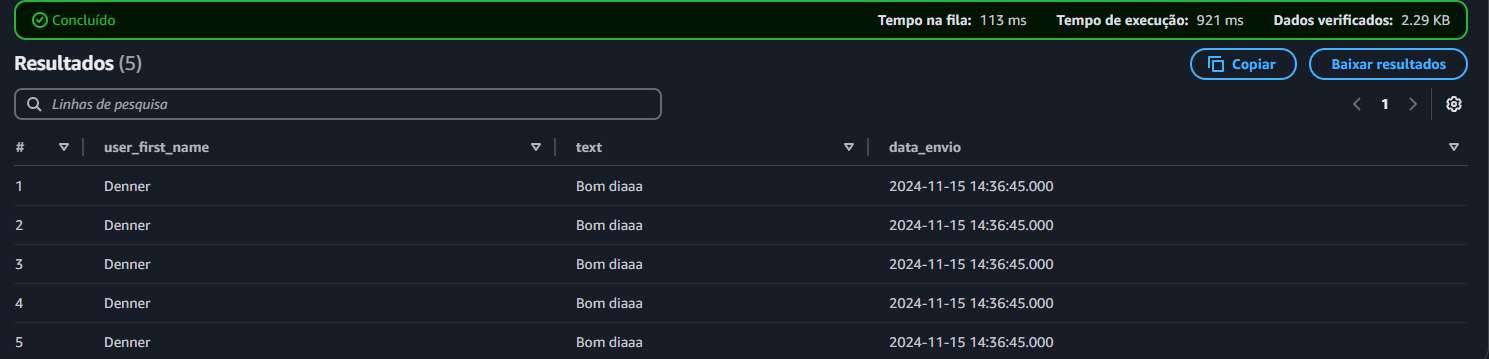

- Horários de Pico de Envio

```sql
SELECT
    HOUR(FROM_UNIXTIME(date)) AS hora,
    COUNT(*) AS total_mensagens
FROM telegram
GROUP BY HOUR(FROM_UNIXTIME(date))
ORDER BY total_mensagens DESC;


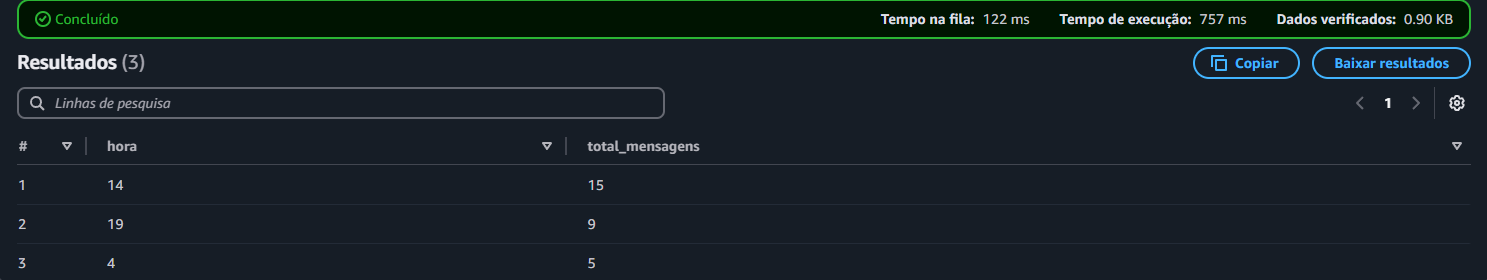

- Resumo Geral



``` sql
SELECT
    COUNT(*) AS total_mensagens,
    COUNT(DISTINCT user_id) AS usuarios_unicos,
    COUNT(DISTINCT chat_id) AS chats_unicos,
    MIN(FROM_UNIXTIME(date)) AS primeira_mensagem,
    MAX(FROM_UNIXTIME(date)) AS ultima_mensagem
FROM telegram;

```



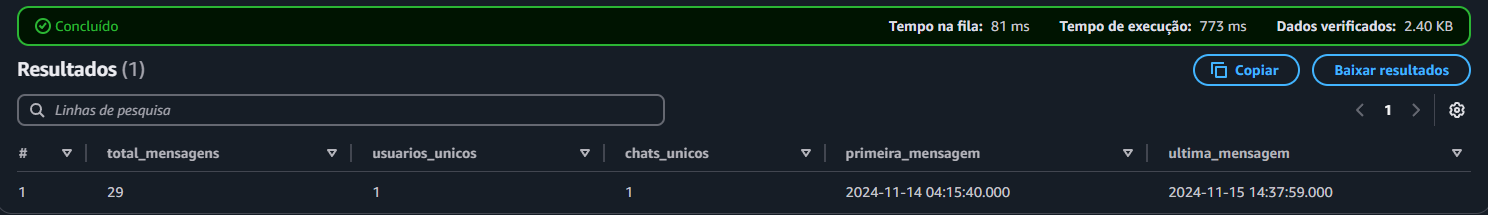

- Relatório Consolidado



```sql
SELECT
    user_first_name,
    COUNT(*) AS total_mensagens,
    COUNT(DISTINCT chat_id) AS chats_participados,
    MIN(FROM_UNIXTIME(date)) AS primeira_mensagem,
    MAX(FROM_UNIXTIME(date)) AS ultima_mensagem
FROM telegram
GROUP BY user_first_name
ORDER BY total_mensagens DESC;

```



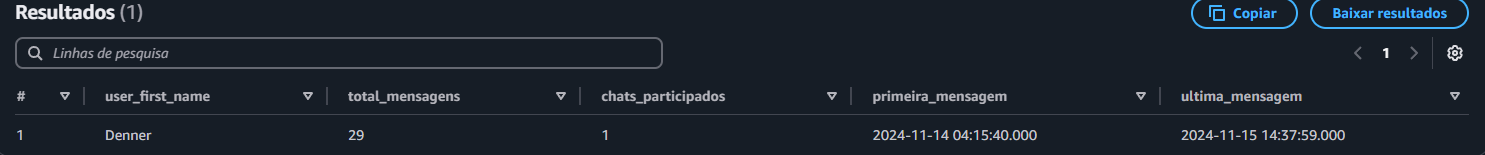

# **7. Conclusão**

A integração entre o **Telegram** e os serviços da **AWS**, estruturada em um pipeline moderno, demonstra como a tecnologia pode transformar dados brutos em informações úteis, prontas para análises. Utilizando o bot no Telegram para captura de mensagens, os dados passam por um fluxo eficiente de ingestão e transformação antes de serem armazenados em formato particionado no **S3** e consultados pelo **Amazon Athena**. Essa arquitetura foi projetada com o uso de ferramentas como **API Gateway, IAM, Lambda, EventBridge e Athena, garantindo escalabilidade, automação e flexibilidade**.

Com o banco de dados estruturado e otimizado, o Athena permite consultas SQL que enriquecem a análise, como identificar os usuários mais ativos, entender padrões de mensagens por dia ou hora, e até encontrar mensagens específicas por palavras-chave, como "AWS". Além disso, o particionamento por data aumenta a eficiência das consultas, reduzindo o tempo de processamento e custos.

Este pipeline é uma solução completa para capturar, processar e analisar grandes volumes de mensagens em tempo real, unindo comunicação moderna e poder computacional em nuvem. Ele não apenas melhora a tomada de decisões baseada em dados, mas também serve como base para aplicações mais complexas no futuro, como machine learning ou relatórios automatizados em ferramentas como **Amazon QuickSight**. A flexibilidade da solução permite sua adaptação a outros cenários, destacando seu valor e impacto para organizações que buscam inovação em suas operações.

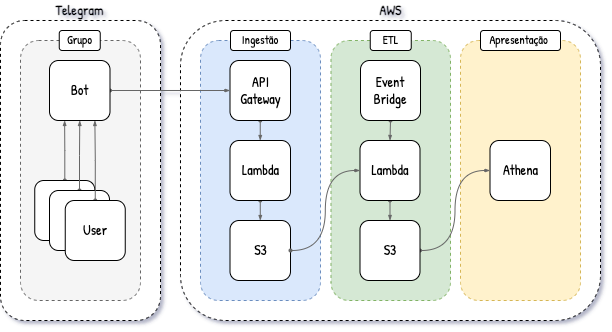